In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [ ]:
import random, re, math
import tensorflow as tf, tensorflow.keras.backend as K
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from time import time

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.MirroredStrategy()

In [4]:
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear = math.pi * shear / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3] )
        
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape( tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3] )    
    
    # ZOOM MATRIX
    zoom_matrix = tf.reshape( tf.concat([one/height_zoom,zero,zero, zero,one/width_zoom,zero, zero,zero,one],axis=0),[3,3] )
    
    # SHIFT MATRIX
    shift_matrix = tf.reshape( tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3] )
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), K.dot(zoom_matrix, shift_matrix))

def transform(image,label):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    DIM = IMG_SIZE
    XDIM = DIM%2 #fix for size 331
    
    rot = 15. * tf.random.normal([1],dtype='float32')
    shr = 5. * tf.random.normal([1],dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    w_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    h_shift = 16. * tf.random.normal([1],dtype='float32') 
    w_shift = 16. * tf.random.normal([1],dtype='float32') 
  
    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image,tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3]),label

In [5]:
BASE_DIR = Path("/kaggle/input/edible-plants-indonesia/dataset")

TRAIN_DIR = BASE_DIR / 'train'
TEST_DIR = BASE_DIR / 'test'

In [6]:
PRE_TRAINED_MODEL = '/kaggle/input/efficientnet-v2/tensorflow2/imagenet21k-ft1k-b3-feature-vector/1'
BATCH_SIZE = 128 if strategy.num_replicas_in_sync > 1 else 16
IMG_SIZE = 300
AUTOTUNE = tf.data.AUTOTUNE

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(TRAIN_DIR,
                                                      validation_split=.2,
                                                      subset="training",
                                                      seed=123,
                                                      image_size=(IMG_SIZE, IMG_SIZE),
                                                      batch_size=None)
val_ds = tf.keras.utils.image_dataset_from_directory(TRAIN_DIR,
                                                     validation_split=.2,
                                                     subset="validation",
                                                     seed=123,
                                                     image_size=(IMG_SIZE, IMG_SIZE),
                                                     batch_size=None)

CLASS_NAMES = train_ds.class_names
STEPS_PER_EPOCH = train_ds.cardinality().numpy() // BATCH_SIZE

Found 766 files belonging to 12 classes.
Using 613 files for training.
Found 766 files belonging to 12 classes.
Using 153 files for validation.


In [8]:
def prepare_ds(ds: tf.data.Dataset, *, training=False):
    if training:
        ds = ds.repeat(strategy.num_replicas_in_sync).shuffle(1024)
        ds = ds.map(transform, AUTOTUNE)
    
    ds = ds.batch(BATCH_SIZE, drop_remainder=True,
                  num_parallel_calls=AUTOTUNE)
    
    return ds.cache().prefetch(AUTOTUNE)
    
train_ds = prepare_ds(train_ds, training=True)
val_ds = prepare_ds(val_ds)

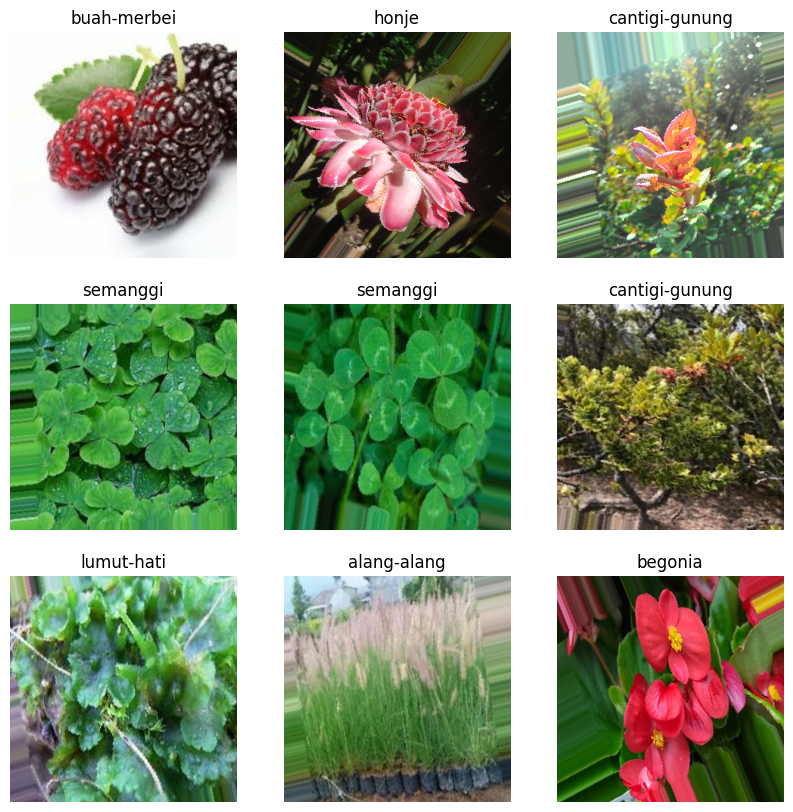

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(CLASS_NAMES[labels[i]])
    plt.axis("off")

In [10]:
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer((IMG_SIZE, IMG_SIZE, 3)),
        tf.keras.layers.Rescaling(1./255),
        hub.KerasLayer(PRE_TRAINED_MODEL, trainable=False),
        tf.keras.layers.Dropout(.5),
        tf.keras.layers.Dense(len(CLASS_NAMES), 'softmax', name="outputs")
    ])

    model.compile('adam', 'sparse_categorical_crossentropy', ['acc'])
    
    return model

In [11]:
MODEL_NAME = 'model'
checkpoint = tf.keras.callbacks.ModelCheckpoint(MODEL_NAME, save_best_only=True, verbose=1,
                                                initial_value_threshold=0.03)

In [12]:
with strategy.scope():
    model = create_model()
    history = model.fit(train_ds, validation_data=val_ds,
                        epochs=32, callbacks=[checkpoint])

Epoch 1/32
37/38 [============================>.] - ETA: 0s - loss: 2.1134 - acc: 0.4611
Epoch 1: val_loss did not improve from 0.04500
38/38 [==============================] - 18s 107ms/step - loss: 2.0781 - acc: 0.4704 - val_loss: 0.4217 - val_acc: 0.9236
Epoch 2/32
37/38 [============================>.] - ETA: 0s - loss: 0.6110 - acc: 0.8057
Epoch 2: val_loss did not improve from 0.04500
38/38 [==============================] - 2s 55ms/step - loss: 0.6106 - acc: 0.8059 - val_loss: 0.1433 - val_acc: 0.9931
Epoch 3/32
37/38 [============================>.] - ETA: 0s - loss: 0.2759 - acc: 0.9206
Epoch 3: val_loss did not improve from 0.04500
38/38 [==============================] - 2s 54ms/step - loss: 0.2759 - acc: 0.9194 - val_loss: 0.1063 - val_acc: 0.9931
Epoch 4/32
37/38 [============================>.] - ETA: 0s - loss: 0.1823 - acc: 0.9459
Epoch 4: val_loss did not improve from 0.04500
38/38 [==============================] - 2s 54ms/step - loss: 0.1830 - acc: 0.9441 - val_loss:

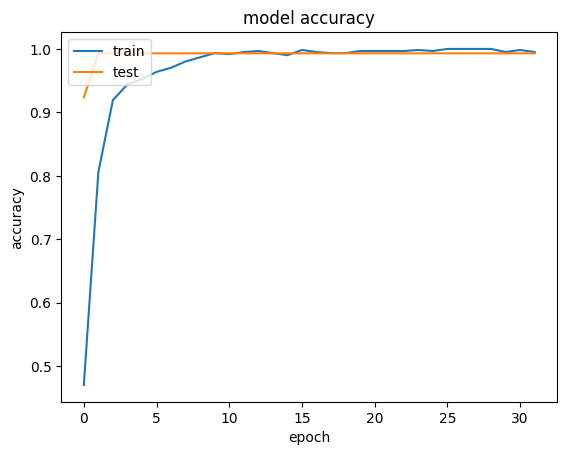

In [13]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

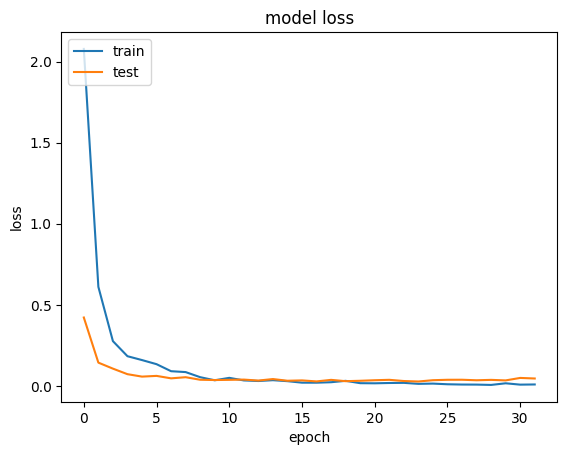

In [14]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
model = tf.keras.models.load_model(MODEL_NAME)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 300, 300, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 1536)              12930622  
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 outputs (Dense)             (None, 12)                18444     
                                                                 
Total params: 12949066 (49.40 MB)
Trainable params: 18444 (72.05 KB)
Non-trainable params: 12930622 (49.33 MB)
_________________________________________________________________


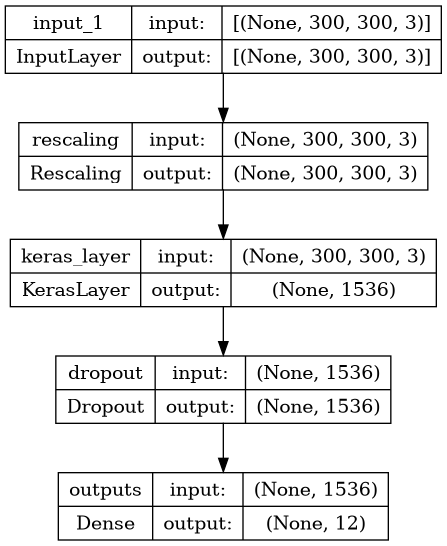

In [16]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [17]:
test_ds = tf.keras.utils.image_dataset_from_directory(TEST_DIR,
                                                      image_size=(IMG_SIZE, IMG_SIZE),
                                                      batch_size=128)
model.evaluate(test_ds)

Found 60 files belonging to 12 classes.
1/1 [==============================] - 3s 3s/step - loss: 0.1174 - acc: 0.9667


[0.1173831969499588, 0.9666666388511658]

In [18]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the model.
TFLITE_FILE_NAME = f'{MODEL_NAME}.tflite'
with open(TFLITE_FILE_NAME, 'wb') as f:
  f.write(tflite_model)

!du -h $TFLITE_FILE_NAME

14M	model.tflite


In [19]:
interpreter = tf.lite.Interpreter(model_path=f"/kaggle/working/{TFLITE_FILE_NAME}")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [20]:
y_pred = []
y_true = []
inference_time = []
test_images = []
for X, y in test_ds.unbatch().batch(1):
    start = time()
    interpreter.set_tensor(input_details[0]['index'], X)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    end = time()
    y_pred.append(np.argmax(output_data))
    y_true.append(y.numpy()[0])
    inference_time.append(end-start)
    test_images.append(X.numpy().astype("uint8"))

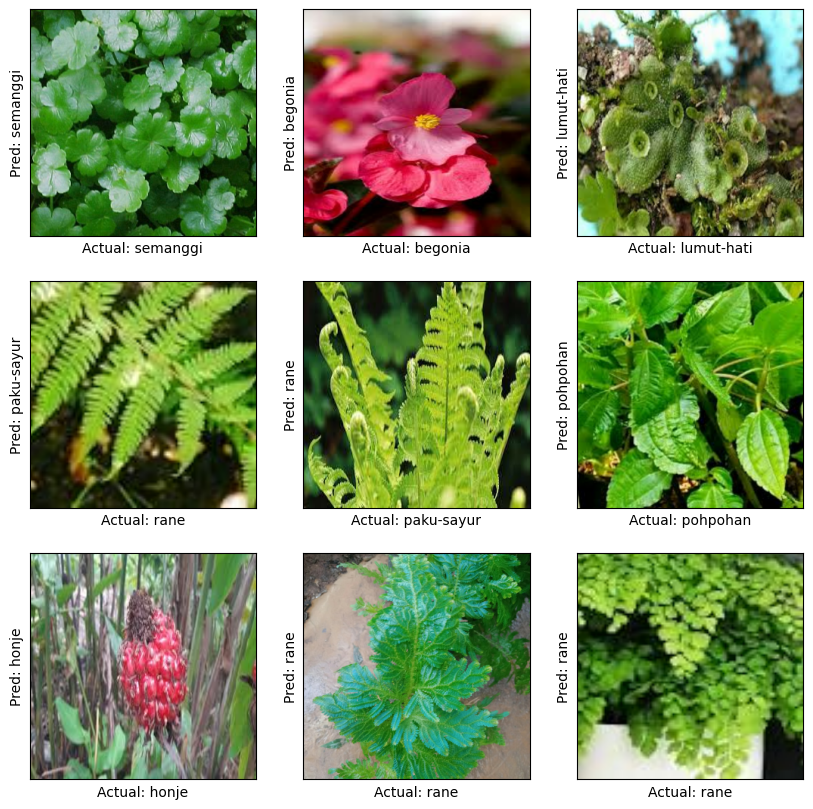

In [21]:
plt.figure(figsize=(10, 10))    
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_images[i][0])
    plt.xlabel("Actual: {}".format(CLASS_NAMES[y_true[i]]))
    plt.ylabel("Pred: {}".format(CLASS_NAMES[y_pred[i]]))

In [22]:
m = tf.keras.metrics.Accuracy()
m.update_state(y_pred, y_true)
print(f"TFLite Model Accuracy: {m.result().numpy():.2%}")
print(f"Inverence Time Average: {np.average(inference_time)*1000:.0f} ms")

TFLite Model Accuracy: 96.67%
Inverence Time Average: 129 ms
